In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# تصنيف أفلام الأوسكار
نهدف لبناء نموذج تصنيف ثنائي للتنبؤ بما إذا كان الفيلم سيُرشح لجائزة الأوسكار أو سيفوز بها، وذلك بالاعتماد على ميزات غير مالية. يتضمن المشروع مراحل معالجة البيانات الأولية، وهندسة الميزات، وتدريب النموذج (باستخدام SMOTE)، بالإضافة إلى التقييم والمقارنة.

# التنبؤ بترشيحات الأوسكار باستخدام التعلم الآلي
بناء نموذج تنبؤي لحالة ترشح الفيلم لجائزة الأوسكار أو فوزه بها، وذلك بالاعتماد على البيانات الوصفية المهيكلة للأفلام.

سوف نستكشف ثلاثة نماذج: CatBoost، وXGBoost، وLightGBM. ستتم مقارنة جميع النماذج بناءً على الدقة (Precision) والاستدعاء (Recall) ومقياس F1 ومنحنى ROC-AUC عبر عتبات مختلفة.

مكاتب

In [ ]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

import lightgbm as lgb
import xgboost as xgb
from google.colab import files
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier






# تحميل البيانات

In [ ]:
# uploaded = files.upload()
# for filename in uploaded.keys():
filename= "/content/drive/MyDrive/lNH_data.csv"
df = pd.read_csv(filename)
print("✅ Data loaded:", df.shape)


✅ Data loaded: (37093, 44)


# معالجة مسبقة للبيانات

In [ ]:
# التحويل لقيم ثنائية 
df['movie_oscar'] = df['movie_oscar'].apply(lambda x: 1 if x > 0 else 0)

# ملئ القيم الفارغة بالمتوسط
df['actors_avg_rating'].fillna(df['actors_avg_rating'].mean(), inplace=True)
df['actors_bayesian_rating'].fillna(df['actors_bayesian_rating'].mean(), inplace=True)

# الترميز Encode
df = pd.get_dummies(df, columns=['original_language'], drop_first=True)

# الترميز عبر MultiLabelBinarizer


genres_split = df['genres_x'].str.split(', ')
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(genres_split)
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
df = pd.concat([df, genres_df], axis=1)

# اختيار السمات
feature_cols = [
    'popularity', 'vote_average', 'vote_count', 'release_year', 'release_month',
    'runtime', 'company_oscars', 'has_superstar_actor',
    'actors_avg_rating', 'actors_bayesian_rating', 'movie_credits_oscar'
] + list(genres_df.columns) + [col for col in df.columns if col.startswith("original_language_")]

X = df[feature_cols]
y = df['movie_oscar']


/tmp/ipython-input-3-1408284171.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['actors_avg_rating'].fillna(df['actors_avg_rating'].mean(), inplace=True)
/tmp/ipython-input-3-1408284171.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

# Train-Test Split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# تعريف توابع التقييم

## هندسة السمات

- **release_season**: Categorical feature based on the release month (e.g., Summer, Fall)
- **actor_oscar_ratio**: Ratio of Oscar-winning cast/crew to total credits (proxy for quality)


In [ ]:
# تابع اسناد الموسم حسب الشهر
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['release_season'] = df['release_month'].apply(get_season)

# نسبة الممثلين الفائزين بالاوسكار
df['actor_oscar_ratio'] = df['movie_credits_oscar'] / df['unique_actors_count'].replace(0, 1)

# one-hot encoding 
df = pd.get_dummies(df, columns=['release_season'], drop_first=True)


In [ ]:

def evaluate_model(name, y_true, y_prob, thresholds=[0.5, 0.6, 0.7]):
    print(f"\n📈 {name} Performance Summary:")
    results = {}
    results['ROC-AUC'] = roc_auc_score(y_true, y_prob)
    print("ROC-AUC:", results['ROC-AUC'])

    for t in thresholds:
        y_pred_t = (y_prob > t).astype(int)
        p = precision_score(y_true, y_pred_t)
        r = recall_score(y_true, y_pred_t)
        f = f1_score(y_true, y_pred_t)
        print(f"Threshold {t:.1f} -> Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}")
        results[f'Precision@{t:.1f}'] = p
        results[f'Recall@{t:.1f}'] = r
        results[f'F1@{t:.1f}'] = f
    return results

##  CatBoost Model


In [ ]:


cat_model = CatBoostClassifier(verbose=0, class_weights=[1, 10])
cat_model.fit(X_train, y_train)

cat_prob = cat_model.predict_proba(X_test)[:, 1]
model_results = {}
model_results["CatBoost"] = evaluate_model("CatBoost", y_test, cat_prob)


📈 CatBoost Performance Summary:
ROC-AUC: 0.9776660143421245
Threshold 0.5 -> Precision: 0.529, Recall: 0.908, F1: 0.669
Threshold 0.6 -> Precision: 0.573, Recall: 0.875, F1: 0.693
Threshold 0.7 -> Precision: 0.617, Recall: 0.836, F1: 0.710


##  XGBoost Model

In [ ]:
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
model_results["XGBoost"] = evaluate_model("XGBoost", y_test, xgb_prob)


📈 XGBoost Performance Summary:
ROC-AUC: 0.9771091558546933
Threshold 0.5 -> Precision: 0.558, Recall: 0.882, F1: 0.683
Threshold 0.6 -> Precision: 0.604, Recall: 0.847, F1: 0.705
Threshold 0.7 -> Precision: 0.647, Recall: 0.816, F1: 0.721


## LightGBM Model

In [ ]:


train_set = lgb.Dataset(X_train, label=y_train)
valid_set = lgb.Dataset(X_test, label=y_test, reference=train_set)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    # 'is_unbalance': True, # Removed this parameter
    'scale_pos_weight': scale_weight,
    'verbosity': -1,
    'seed': 42
}

lgb_model = lgb.train(params, train_set, valid_sets=[valid_set], num_boost_round=100)

lgb_prob = lgb_model.predict(X_test)
model_results["LightGBM"] = evaluate_model("LightGBM", y_test, lgb_prob)


📈 LightGBM Performance Summary:
ROC-AUC: 0.9773124840621596
Threshold 0.5 -> Precision: 0.552, Recall: 0.893, F1: 0.682
Threshold 0.6 -> Precision: 0.586, Recall: 0.860, F1: 0.697
Threshold 0.7 -> Precision: 0.627, Recall: 0.822, F1: 0.711


## التجميع الطبقي (Stacking Ensemble)
سنقوم الآن بدمج نماذج CatBoost و XGBoost و LightGBM باستخدام نموذج ميتا (الانحدار اللوجستي) لإنشاء تجميع طبقي. قد يؤدي ذلك إلى تحسين دقة التنبؤ الإجمالية من خلال الاستفادة من نقاط قوة كل نموذج أساسي.


In [ ]:

# توليد توقعات النموذج الأساسي على بيانات التدريب
cat_train_prob = cat_model.predict_proba(X_train)[:, 1]
xgb_train_prob = xgb_model.predict_proba(X_train)[:, 1]
lgb_train_prob = lgb_model.predict(X_train)

# دمج التوقعات الى سمات-ميتا 
stacked_train = pd.DataFrame({
    "catboost": cat_train_prob,
    "xgboost": xgb_train_prob,
    "lightgbm": lgb_train_prob
})

# Logistic regression
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')
meta_model.fit(stacked_train, y_train)

# Generate base model predictions on test data
cat_test_prob = cat_model.predict_proba(X_test)[:, 1]
xgb_test_prob = xgb_model.predict_proba(X_test)[:, 1]
lgb_test_prob = lgb_model.predict(X_test)

stacked_test = pd.DataFrame({
    "catboost": cat_test_prob,
    "xgboost": xgb_test_prob,
    "lightgbm": lgb_test_prob
})

# النتائج و التقييم
stacked_prob = meta_model.predict_proba(stacked_test)[:, 1]

model_results["Stacking Ensemble"] = evaluate_model("Stacking Ensemble", y_test, stacked_prob)


📈 Stacking Ensemble Performance Summary:
ROC-AUC: 0.9714575010238856
Threshold 0.5 -> Precision: 0.630, Recall: 0.826, F1: 0.715
Threshold 0.6 -> Precision: 0.643, Recall: 0.816, F1: 0.719
Threshold 0.7 -> Precision: 0.652, Recall: 0.796, F1: 0.717


## Random Forest Classifier



In [ ]:

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

rf_prob = rf_model.predict_proba(X_test)[:, 1]
model_results["Random Forest"] = evaluate_model("Random Forest", y_test, rf_prob)


📈 Random Forest Performance Summary:
ROC-AUC: 0.9711492486998585
Threshold 0.5 -> Precision: 0.867, Recall: 0.495, F1: 0.630
Threshold 0.6 -> Precision: 0.922, Recall: 0.408, F1: 0.566
Threshold 0.7 -> Precision: 0.970, Recall: 0.314, F1: 0.475


## Logistic Regression



In [ ]:

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train, y_train)

lr_prob = lr_model.predict_proba(X_test)[:, 1]
model_results["Logistic Regression"] = evaluate_model("Logistic Regression", y_test, lr_prob)


📈 Logistic Regression Performance Summary:
ROC-AUC: 0.838349003933266
Threshold 0.5 -> Precision: 0.232, Recall: 0.783, F1: 0.358
Threshold 0.6 -> Precision: 0.284, Recall: 0.706, F1: 0.405
Threshold 0.7 -> Precision: 0.360, Recall: 0.569, F1: 0.441


## تطبيق SMOTE لجميع النماذج
لتحسين الأداء على الفئة الأقلية، نطبق تقنية SMOTE (تقنية زيادة العينات الاصطناعية للأقلية) لموازنة مجموعة البيانات قبل تدريب جميع النماذج.


In [ ]:

# تطبيق عللا بيانات التدريب
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"Original training samples: {len(X_train)}")
print(f"Balanced training samples: {len(X_train_bal)}")


Original training samples: 29674
Balanced training samples: 54486


## اعادة التدريب على بيانات متوازنة

## **CatBoost**

In [32]:
cat_model = CatBoostClassifier(verbose=0, class_weights=[1, 10])
cat_model.fit(X_train_bal, y_train_bal)
cat_prob = cat_model.predict_proba(X_test)[:, 1]
model_results["CatBoost (SMOTE)"] = evaluate_model("CatBoost (SMOTE)", y_test, cat_prob)


📈 CatBoost (SMOTE) Performance Summary:
ROC-AUC: 0.9724041121560324
Threshold 0.5 -> Precision: 0.418, Recall: 0.962, F1: 0.583
Threshold 0.6 -> Precision: 0.444, Recall: 0.959, F1: 0.607
Threshold 0.7 -> Precision: 0.464, Recall: 0.919, F1: 0.617


### **XGBoost** 

In [ ]:

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
model_results["XGBoost (SMOTE)"] = evaluate_model("XGBoost (SMOTE)", y_test, xgb_prob)


📈 XGBoost (SMOTE) Performance Summary:
ROC-AUC: 0.9704106746825956
Threshold 0.5 -> Precision: 0.574, Recall: 0.793, F1: 0.666
Threshold 0.6 -> Precision: 0.628, Recall: 0.743, F1: 0.681
Threshold 0.7 -> Precision: 0.659, Recall: 0.689, F1: 0.674


### **LightGBM** 

In [ ]:

lgb_model = LGBMClassifier(objective='binary', metric='binary_logloss', boosting_type='gbdt', verbosity=-1, seed=42)
lgb_model.fit(X_train_bal, y_train_bal)
lgb_prob = lgb_model.predict_proba(X_test)[:, 1]
model_results["LightGBM (SMOTE)"] = evaluate_model("LightGBM (SMOTE)", y_test, lgb_prob)


📈 LightGBM (SMOTE) Performance Summary:
ROC-AUC: 0.9726250685810105
Threshold 0.5 -> Precision: 0.596, Recall: 0.785, F1: 0.677
Threshold 0.6 -> Precision: 0.631, Recall: 0.727, F1: 0.676
Threshold 0.7 -> Precision: 0.692, Recall: 0.671, F1: 0.681


###  **Random Forest**

In [35]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
rf_prob = rf_model.predict_proba(X_test)[:, 1]
model_results["Random Forest (SMOTE)"] = evaluate_model("Random Forest (SMOTE)", y_test, rf_prob)


📈 Random Forest (SMOTE) Performance Summary:
ROC-AUC: 0.9657922024356884
Threshold 0.5 -> Precision: 0.594, Recall: 0.730, F1: 0.655
Threshold 0.6 -> Precision: 0.665, Recall: 0.633, F1: 0.649
Threshold 0.7 -> Precision: 0.753, Recall: 0.512, F1: 0.609


### **Logistic Regression**

In [36]:
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_bal, y_train_bal)
lr_prob = lr_model.predict_proba(X_test)[:, 1]
model_results["Logistic Regression (SMOTE)"] = evaluate_model("Logistic Regression (SMOTE)", y_test, lr_prob)


📈 Logistic Regression (SMOTE) Performance Summary:
ROC-AUC: 0.7828614122665347
Threshold 0.5 -> Precision: 0.219, Recall: 0.664, F1: 0.329
Threshold 0.6 -> Precision: 0.257, Recall: 0.566, F1: 0.354
Threshold 0.7 -> Precision: 0.293, Recall: 0.438, F1: 0.351


### **Stacking Ensemble**

In [ ]:
cat_train_prob = cat_model.predict_proba(X_train_bal)[:, 1]
xgb_train_prob = xgb_model.predict_proba(X_train_bal)[:, 1]
lgb_train_prob = lgb_model.predict_proba(X_train_bal)[:, 1]

stacked_train = pd.DataFrame({
    "catboost": cat_train_prob,
    "xgboost": xgb_train_prob,
    "lightgbm": lgb_train_prob
})

meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')
meta_model.fit(stacked_train, y_train_bal)

cat_test_prob = cat_model.predict_proba(X_test)[:, 1]
xgb_test_prob = xgb_model.predict_proba(X_test)[:, 1]
lgb_test_prob = lgb_model.predict_proba(X_test)[:, 1]

stacked_test = pd.DataFrame({
    "catboost": cat_test_prob,
    "xgboost": xgb_test_prob,
    "lightgbm": lgb_test_prob
})

stacked_prob = meta_model.predict_proba(stacked_test)[:, 1]
model_results["Stacking Ensemble (SMOTE)"] = evaluate_model("Stacking Ensemble (SMOTE)", y_test, stacked_prob)


📈 Stacking Ensemble (SMOTE) Performance Summary:
ROC-AUC: 0.9727619891197676
Threshold 0.5 -> Precision: 0.619, Recall: 0.755, F1: 0.681
Threshold 0.6 -> Precision: 0.636, Recall: 0.730, F1: 0.680
Threshold 0.7 -> Precision: 0.657, Recall: 0.711, F1: 0.682


## تصور مقاييس أداء النموذج


<Figure size 1200x600 with 0 Axes>

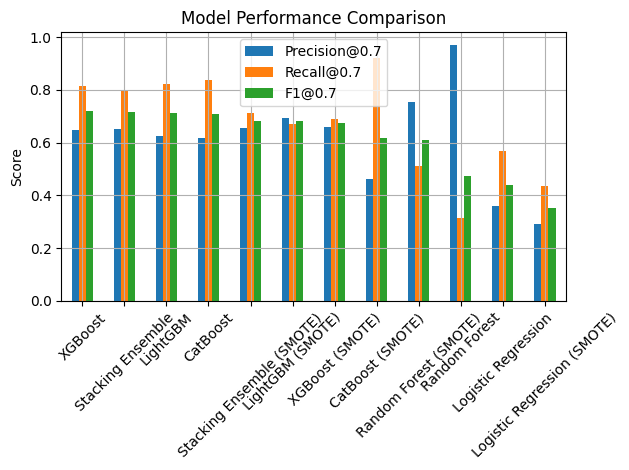

In [ ]:


results_df = pd.DataFrame(model_results).T.sort_values("F1@0.7", ascending=False)

plt.figure(figsize=(12, 6))
results_df[['Precision@0.7', 'Recall@0.7', 'F1@0.7']].plot(kind='bar', title="Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importance from Random Forest

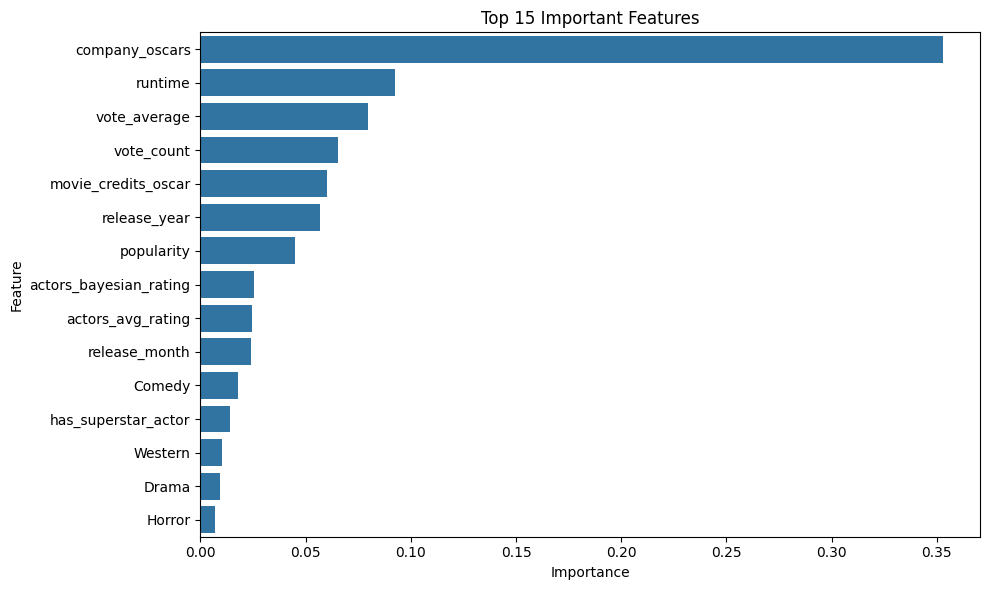

In [39]:
importances = rf_model.feature_importances_
feature_names = X_train.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(15))
plt.title("Top 15 Important Features")
plt.tight_layout()
plt.show()


## اضافة سمات متعلقة اكثر بالمجال

In [40]:
df['tagline_length'] = df['tagline'].apply(lambda x: len(str(x)))
df['strong_sentiment'] = df['tagline_sentiment'].apply(lambda x: 1 if x >= 2 else 0)
